In [1]:
import os
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import multiprocessing
# multiprocessing.set_start_method('forkserver')
from torch.utils.data import DataLoader
from LatentPixel import TGraph, init_render, get_pixel_pretrain_dataloader, ModelType, RenderConfig, LPixelForPreTraining
from tqdm import tqdm

from datasets import load_dataset
from LatentPixel import get_pixel_pretrain_dataloader

torch.no_grad().__enter__()

In [2]:
model = LPixelForPreTraining(ModelType.SD, 0.25, [4, 32 * 529 // 8], 4, 'storage/pixel-base', 'storage/SD2_VQGAN', keep_decoder=True, init_connection_layer=True)

Some weights of PIXELForPreTraining were not initialized from the model checkpoint at storage/pixel-base and are newly initialized because the shapes did not match:
- vit.embeddings.patch_embeddings.projection.weight: found shape torch.Size([768, 3, 16, 16]) in the checkpoint and torch.Size([768, 4, 4, 4]) in the model instantiated
- decoder.decoder_pred.weight: found shape torch.Size([768, 512]) in the checkpoint and torch.Size([64, 512]) in the model instantiated
- decoder.decoder_pred.bias: found shape torch.Size([768]) in the checkpoint and torch.Size([64]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Reinitialize the connection layers


In [3]:
font_file='PixeloidSans-mLxMm.ttf'
init_render(RenderConfig(dpi=240, pixels_per_patch=32, font_size=8))
text = '这是一些中文 Alice was everywhere, until she wasn’t. Just like at first, she was nowhere until she was. The absence of her before I knew she existed, was nothing. Now, the absence of her shrouds everything. Like a guest who never came to dinner; a stormy sky that didn’t deliver. Nothing can wash away the void where she used to be. This is what I’m thinking about the first time I take The Walk without her. I met Alice at a dinner party, the raucous kind with wild guests, beautiful people glittering in late summer air on a second-floor balcony backlit by a September sky. We were all friends of Richard, and this was his brilliant attempt to make all the people I love come together. Or it was a lavish birthday party thrown for himself. You could never quite tell with Richard. He was my hairdresser, but I was included among the people he loved the most, and so was Alice. From across the table, her eyes kept locking mine with interest: hers large and dark and layered with mischief. Her husband was older, serene. A balm to her boisterousness.'
print(text)

这是一些中文 Alice was everywhere, until she wasn’t. Just like at first, she was nowhere until she was. The absence of her before I knew she existed, was nothing. Now, the absence of her shrouds everything. Like a guest who never came to dinner; a stormy sky that didn’t deliver. Nothing can wash away the void where she used to be. This is what I’m thinking about the first time I take The Walk without her. I met Alice at a dinner party, the raucous kind with wild guests, beautiful people glittering in late summer air on a second-floor balcony backlit by a September sky. We were all friends of Richard, and this was his brilliant attempt to make all the people I love come together. Or it was a lavish birthday party thrown for himself. You could never quite tell with Richard. He was my hairdresser, but I was included among the people he loved the most, and so was Alice. From across the table, her eyes kept locking mine with interest: hers large and dark and layered with mischief. Her husband was

/home/tai/miniconda3/envs/pt2hfpy310/lib/python3.10/site-packages/transformers/modeling_utils.py:866: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


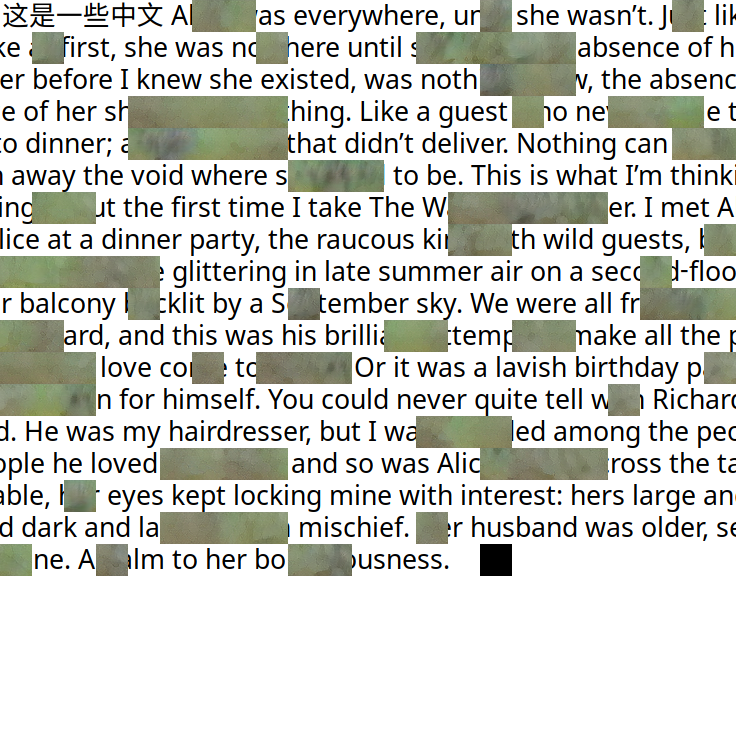

In [4]:
tmg = TGraph.from_text(text)

model.coder.eval()
model.pixel.train()
pixel_values = tmg.unsquarelize().to_SD()
attention_mask = tmg.get_attention_mask()
patch_mask = tmg.get_span_mask()

result = model.forward(pixel_values.unsqueeze(0), attention_mask.unsqueeze(0), patch_mask.unsqueeze(0))

rimg = TGraph.from_SD(result.logits, True)
rimg._mask = result.mask
recon = TGraph.reconstruct(tmg, rimg)
recon.to_PIL()[0]

In [5]:
result.logits.shape

torch.Size([1, 3, 32, 16928])

16928
torch.Size([1, 529])
torch.Size([1, 529, 3072])


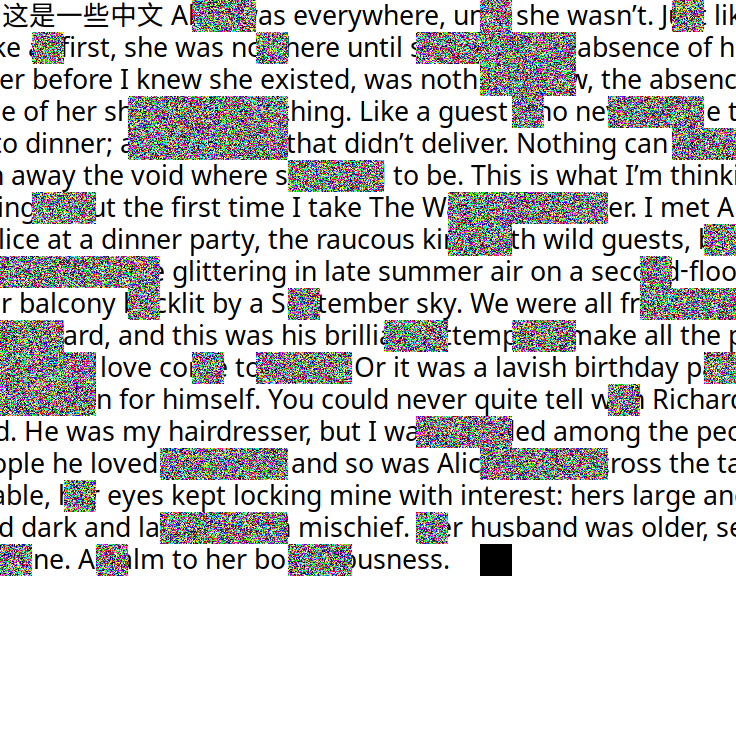

In [16]:
recon.circle_mask('noise', 1)
recon.squarelize().to_PIL()[0]

In [6]:
23 *23 *32 *32 *3

1625088

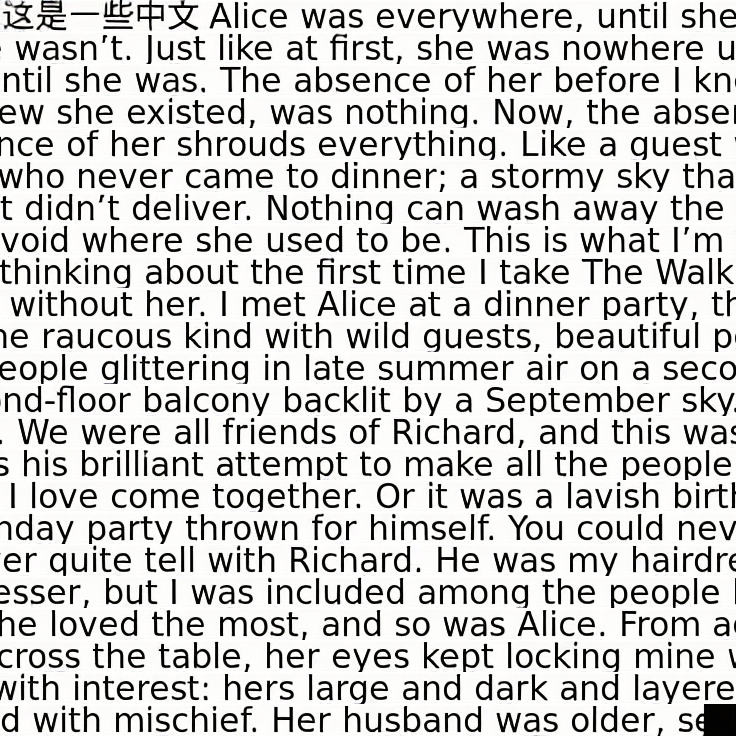

In [19]:
recon = model.coder(tmg.unsquarelize().to_SD().unsqueeze(0))
TGraph.from_SD(recon.sample, True).squarelize().to_PIL()[0]

In [7]:
dataloader = get_pixel_pretrain_dataloader(
        paths=['storage/enwiki/', 'storage/bookcorpus'],
        batch_size=2, 
        num_workers=8, 
        min_len=600,
        seed=42,
        model_type=None,
        render_config=RenderConfig(dpi=240, pixels_per_patch=32)
)

Datasets loaded from ['storage/bookcorpus', 'storage/enwiki/']
Convert the dataset into a streaming dataset
128
128
Begin to interleave datasets
<function get_pixel_pretrain_dataloader at 0x7f00abcb6d40> used 2.712045431137085 seconds.


In [8]:
batches = []
idx = 0
for batch in dataloader:
    idx += 1
    batches.append(batch)
    if idx > 5:
        break

pid 2853849's current affinity mask: 1000000001
pid 2853849's new affinity mask: ffffffffff
pid 2854228's current affinity mask: 1000000001
pid 2854228's new affinity mask: ffffffffff
pid 2853989's current affinity mask: 1000000001
pid 2853989's new affinity mask: ffffffffff
pid 2853912's current affinity mask: 1000000001
pid 2853912's new affinity mask: ffffffffff
pid 2854164's current affinity mask: 1000000001
pid 2854164's new affinity mask: ffffffffff
pid 2854101's current affinity mask: 1000000001
pid 2854101's new affinity mask: ffffffffff
pid 2853975's current affinity mask: 1000000001
pid 2853975's new affinity mask: ffffffffff
pid 2854165's current affinity mask: 1000000001
pid 2854165's new affinity mask: ffffffffff


In [9]:
smask = batch.get_span_mask()
smask.shape

torch.Size([2, 529])

In [10]:
smask[0]

tensor([0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
        1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,

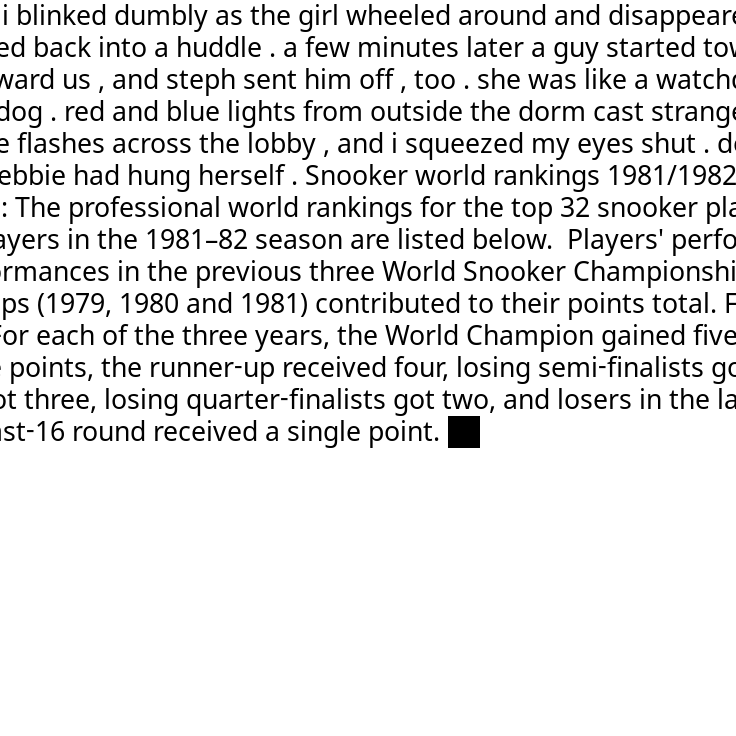

In [11]:
batch.squarelize().to_PIL()[0]

In [24]:
img = batches[0]._value[:, :, :, :32]

In [25]:
img.shape

torch.Size([5, 3, 32, 32])

In [22]:
batches[0].unsquarelize()

In [36]:
batch = batches[1]

In [6]:
batch = next(iter(dataloader))

pid 4116485's current affinity mask: 1000000001
pid 4116485's new affinity mask: ffffffffff
pid 4116765's current affinity mask: 1000000001
pid 4116765's new affinity mask: ffffffffff
pid 4116611's current affinity mask: 1000000001
pid 4116611's new affinity mask: ffffffffff
pid 4116421's current affinity mask: 1000000001
pid 4116421's new affinity mask: ffffffffff
pid 4116707's current affinity mask: 1000000001
pid 4116707's new affinity mask: ffffffffff
pid 4116484's current affinity mask: 1000000001
pid 4116484's new affinity mask: ffffffffff
pid 4116548's current affinity mask: 1000000001
pid 4116548's new affinity mask: ffffffffff
pid 4116800's current affinity mask: 1000000001
pid 4116800's new affinity mask: ffffffffff


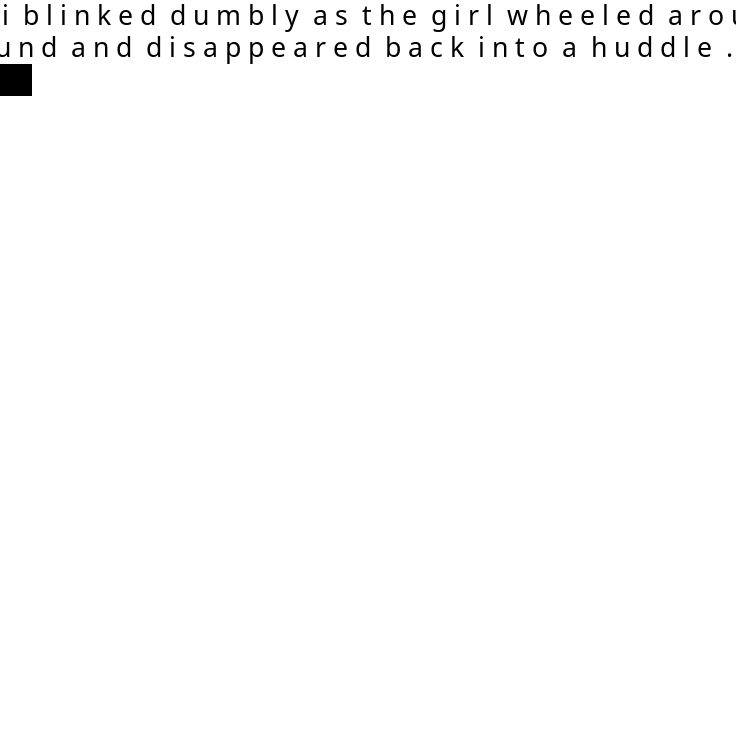

In [5]:
batch.squarelize().to_PIL()[0]

In [27]:
recon = model.coder(img)

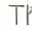

In [35]:
recongraph = TGraph.from_SD(recon.sample)
recongraph.to_PIL()[4]

In [34]:
img = TGraph.from_text(text)
print(img._value.shape)

torch.Size([3, 32, 16928])


In [6]:
pixel_values.shape

torch.Size([3, 32, 16928])

In [7]:
pixel_values.shape

torch.Size([3, 32, 16928])

/home/tai/miniconda3/envs/pt2hfpy310/lib/python3.10/site-packages/transformers/modeling_utils.py:866: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [9]:
result.loss

tensor(1.1137, grad_fn=<DivBackward0>)

In [13]:
recon.circle_mask('green', 0.5)

TypeError: tensor() takes 1 positional argument but 2 were given

In [6]:
data_paths = ['storage/enwiki', 'storage/bookcorpus']
loader = get_pixel_pretrain_dataloader(
    paths=data_paths,
    batch_size=64,
    num_workers=1,
    seed=42,
    model_type=None,
    pin_memory_device='cpu',
    streaming=True
)

Datasets loaded from ['storage/bookcorpus', 'storage/enwiki']
Convert the dataset into a streaming dataset
128
128
Begin to interleave datasets
128
128


In [7]:
it = iter(loader)
for i in tqdm(range(300)):
    batch = next(it)
    # batch.to_device('cuda')
    # batch.to_SD()

pid 498435's current affinity mask: 1000000001
pid 498435's new affinity mask: ffffffffff


100%|██████████| 300/300 [01:42<00:00,  2.92it/s]


In [8]:
batch.to_pixel()

tensor([[[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 0.6157,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 0.6157,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 0.6157,  ..., 1

In [129]:
mask = [1, 0, 0, 0, 1]

In [130]:
def mask2img(mask: torch.Tensor | list[int] | list[list[int]], patch_size: int) -> torch.Tensor:
    if isinstance(mask, list):
        mask = torch.tensor(mask)
    if mask.dim() == 2:
        num_mask = mask.shape[0]
    else:
        assert mask.dim() == 1
        num_mask = 1

    olen = mask.shape[-1]
    return mask \
        .reshape(-1) \
        .repeat(patch_size**2)  \
        .reshape(-1, olen * num_mask) \
        .transpose(-1, -2) \
        .reshape(-1, olen * patch_size, patch_size) \
        .transpose(-1, -2) \
        .squeeze() \
        .contiguous()


In [133]:
mask2img(mask, 16)

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])